In [1]:
from fastai2.basics           import *
from fastai2.vision.all       import *
from fastai2.medical.imaging  import *

np.set_printoptions(linewidth=120)
matplotlib.rcParams['image.cmap'] = 'bone'
set_num_threads(1)
set_seed(42)

path = Path('~/data/rsna').expanduser()
path_trn = path/'stage_2_train'
path_tst = path/'stage_2_test'

torch.cuda.set_device(1)

In [3]:
path_meta = path/'meta'
df_lbls = pd.read_feather(path_meta/'labels.fth')
df_tst = pd.read_feather(path_meta/'df_tst.fth')
df_trn = pd.read_feather(path_meta/'df_trn.fth').dropna(subset=['img_pct_window'])
bins = (path_meta/'bins.pkl').load()

In [2]:
# comb = df_trn.join(df_lbls.set_index('ID'), 'SOPInstanceUID')
# comb.reset_index(drop=True).to_feather(path/'df_comb2.fth')

In [5]:
def df2dcm(df): return L((path_trn/o).dcmread() for o in df.fname.values)

In [6]:
def fix_pxrepr(dcm):
    if dcm.PixelRepresentation != 0 or dcm.RescaleIntercept<-100: return
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

In [7]:
htypes = 'any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural'

In [8]:
def dcm_tfm(fn): 
    fn = Path(fn)
    try:
        x = fn.dcmread()
        fix_pxrepr(x)
    except Exception as e:
        print(fn,e)
        raise SkipItemException
    if x.Rows != 512 or x.Columns != 512: x.zoom_to((512,512))
    return x.scaled_px

In [9]:
fns = list(df_tst.fname.values)
# fns = list(comb.fname.values)
len(fns)

121232

In [10]:
# dest = path/'nocrop_jpg256'
# dest = path/'nocrop_jpg'
dest = path/'tst_jpg'
dest.mkdir(exist_ok=True)

In [11]:
bs=512

In [12]:
# fns2 = set([o.with_suffix('').name for o in dest.ls()])
# fns3 = set([Path(o).with_suffix('').name for o in fns])
# fns4 = [o for o in fns3 if o not in fns2]
# fns5 = [path_trn/Path(o).with_suffix('.dcm') for o in fns4]

# len(fns5)

In [13]:
dsrc = DataSource(fns, [[dcm_tfm],[os.path.basename]])
dl = TfmdDL(dsrc, bs=bs, num_workers=2)

In [14]:
def dest_fname(fname): return dest/Path(fname).with_suffix('.jpg')

def save_cropped_jpg(o, dest):
    fname,px = o
    wins = (dicom_windows.brain, dicom_windows.subdural, dicom_windows.abdomen_soft)
    px.save_jpg(dest_fname(fname), wins, bins=bins)

In [15]:
tfm = AffineCoordTfm(size=256)

In [16]:
tfm = noop

In [17]:
def process_batch(pxs, fnames, n_workers=4):
    pxs = tfm(TensorImage(pxs.unsqueeze(1)).cuda()).cpu().squeeze(1)
    parallel(save_cropped_jpg, zip(fnames, pxs), n_workers=n_workers, progress=False, dest=dest)

In [22]:
# Uncomment this to test and time a single batch

%time process_batch(*dl.one_batch(), n_workers=12)

CPU times: user 2.19 s, sys: 2.61 s, total: 4.79 s
Wall time: 6.4 s


In [23]:
for b in progress_bar(dl): process_batch(*b, n_workers=8)

In [29]:
dest

PosixPath('/home/jhoward/data/rsna/tst_jpg')

In [24]:
fns = dest.ls(1000)

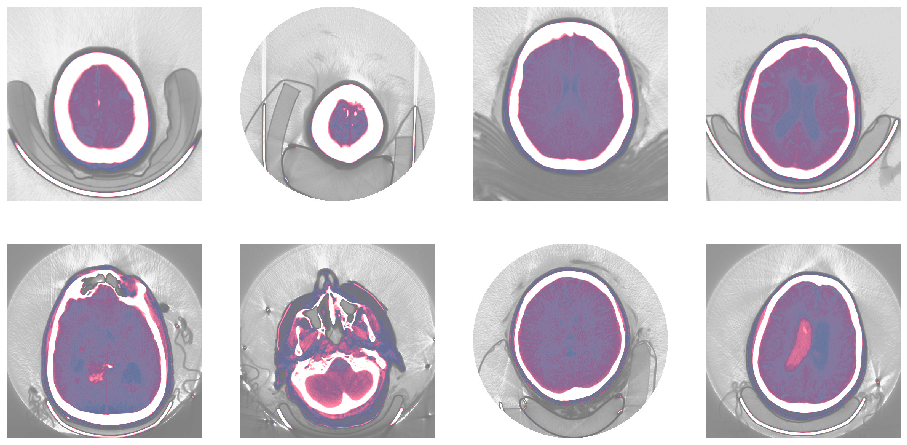

In [25]:
for i,(ax,fn) in enumerate(zip(subplots(2,4)[1].flat,fns)):
    jpgfn = dest/Path(fn).with_suffix('.jpg').name
    show_image(Image.open(jpgfn), ax=ax)

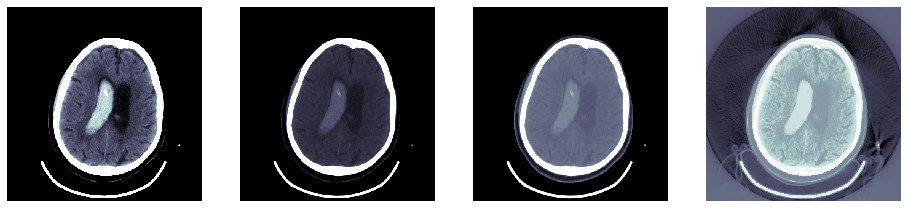

In [26]:
t = tensor(Image.open(jpgfn))
show_images(t.permute(2,0,1))

In [27]:
t.shape

torch.Size([512, 512, 4])